# Sentence Clustering With all-mpnet-base-v2

In [1]:
import random
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hdbscan
import umap
import tensorflow as tf
import tensorflow_hub as hub
from sentence_transformers import SentenceTransformer
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from tqdm.notebook import trange
from hyperopt import fmin, tpe, hp, STATUS_OK, space_eval, Trials

pd.set_option("display.max_rows", 600)
pd.set_option("display.max_columns", 500)
pd.set_option("max_colwidth", 400)

## Load data and pre-trained models

In [31]:
data_sample = pd.read_csv('D:\\NLP\\Frame_NLP\\archive\\Sent_Cluster\\labeled_clusters1229.csv')
data_sample.rename(columns = {'label':'category'}, inplace = True)
data_sample.head()

,Processed_Title,label_st1,category
0,"US coronavirus death toll rises to 14, most cases in Washington",1044,rises_37_coronavirus_death
1,"Iran rejects U.S. offer for coronavirus aid, cites conspiracy theory",576,refuses_offer_coronavirus_conspiracy
2,TSA is making 3 changes to stop coronavirus from spreading on planes,913,expands_change_airport_coronavirus
3,NBA Players to Take Pay Cut Amidst Coronavirus Crisis,758,preparing_cut_coronavirus_game
4,"Coronavirus Cases confirmed in North Korea, say officials",355,coronavirus_exercise_case_week


In [32]:
all_title = list(data_sample['Processed_Title'])
len(all_title)

8376

In [33]:
all_title[:10]

['US coronavirus death toll rises to 14, most cases in Washington',
 'Iran rejects U.S. offer for coronavirus aid, cites conspiracy theory',
 'TSA is making 3 changes to stop coronavirus from spreading on planes',
 'NBA Players to Take Pay Cut Amidst Coronavirus Crisis',
 'Coronavirus Cases confirmed in North Korea, say officials',
 'Mayor Greg Fischer more coronavirus cases than thought',
 'Number Of Confirmed Coronavirus Cases In Southern Germany Rises To 4 Health Ministry',
 'Coronavirus live updates: US President Donald Trump declares coronavirus pandemic a national emergency',
 'South Africa Starts Easing Coronavirus Lockdown',
 'Coronavirus: Ekiti state government declares 14 day curfew']

In [34]:
model_st1 = SentenceTransformer('all-mpnet-base-v2')

In [35]:
def embed(model, model_type, sentences):
    if model_type == 'use':
        embeddings = model(sentences)
    elif model_type == 'sentence transformer':
        embeddings = model.encode(sentences, show_progress_bar=True)
    
    return embeddings

In [36]:
embeddings_st1 = embed(model_st1, 'sentence transformer', all_title)

Batches:   0%|          | 0/262 [00:00<?, ?it/s]

In [37]:
embeddings = [embeddings_st1]

for embedding in embeddings:
    print(embedding.shape)

(8376, 768)


## Assitant Functions

In [38]:
def generate_clusters(message_embeddings,
                      n_neighbors,
                      n_components, 
                      min_cluster_size,
                      min_samples = None,
                      random_state = None):
    """
    Returns HDBSCAN objects after first performing dimensionality reduction using UMAP
    
    Arguments:
        message_embeddings: embeddings to use
        n_neighbors: int, UMAP hyperparameter n_neighbors
        n_components: int, UMAP hyperparameter n_components
        min_cluster_size: int, HDBSCAN hyperparameter min_cluster_size
        min_samples: int, HDBSCAN hyperparameter min_samples
        random_state: int, random seed
        
    Returns:
        clusters: HDBSCAN object of clusters
    """
    
    umap_embeddings = (umap.UMAP(n_neighbors = n_neighbors, 
                                n_components = n_components, 
                                metric = 'cosine', 
                                random_state=random_state)
                            .fit_transform(message_embeddings))

    clusters = hdbscan.HDBSCAN(min_cluster_size = min_cluster_size, 
                               min_samples = min_samples,
                               metric='euclidean', 
                               gen_min_span_tree=True,
                               cluster_selection_method='eom').fit(umap_embeddings)
    
    return clusters

In [39]:
def score_clusters(clusters, prob_threshold = 0.05):
    """
    Returns the label count and cost of a given clustering

    Arguments:
        clusters: HDBSCAN clustering object
        prob_threshold: float, probability threshold to use for deciding
                        what cluster labels are considered low confidence

    Returns:
        label_count: int, number of unique cluster labels, including noise
        cost: float, fraction of data points whose cluster assignment has
              a probability below cutoff threshold
    """
    
    cluster_labels = clusters.labels_
    label_count = len(np.unique(cluster_labels))
    total_num = len(clusters.labels_)
    cost = (np.count_nonzero(clusters.probabilities_ < prob_threshold)/total_num)
    
    return label_count, cost

In [40]:
def random_search(embeddings, space, num_evals):
    """
    Randomly search parameter space of clustering pipeline

    Arguments:
        embeddings: embeddings to use
        space: dict, contains keys for 'n_neighbors', 'n_components',
               and 'min_cluster_size' and values with
               corresponding lists or ranges of parameters to search
        num_evals: int, number of random parameter combinations to try

    Returns:
        df_result: pandas dataframe containing info on each evaluation
                   performed, including run_id, parameters used, label
                   count, and cost
    """
    
    results = []
    
    for i in trange(num_evals):
        n_neighbors = random.choice(space['n_neighbors'])
        n_components = random.choice(space['n_components'])
        min_cluster_size = random.choice(space['min_cluster_size'])
        random_state = space['random_state']
        
        clusters = generate_clusters(embeddings, 
                                     n_neighbors=n_neighbors, 
                                     n_components=n_components, 
                                     min_cluster_size=min_cluster_size, 
                                     random_state=random_state)
    
        label_count, cost = score_clusters(clusters, prob_threshold = 0.05)
                
        results.append([i, n_neighbors, n_components, min_cluster_size, label_count, cost])
    
    result_df = pd.DataFrame(results, columns=['run_id', 'n_neighbors', 'n_components', 
                                               'min_cluster_size', 'label_count', 'cost'])
    
    return result_df.sort_values(by='cost')

In [41]:
def objective(params, embeddings, label_lower, label_upper):
    """
    Objective function for hyperopt to minimize

    Arguments:
        params: dict, contains keys for 'n_neighbors', 'n_components',
               'min_cluster_size', 'random_state' and
               their values to use for evaluation
        embeddings: embeddings to use
        label_lower: int, lower end of range of number of expected clusters
        label_upper: int, upper end of range of number of expected clusters

    Returns:
        loss: cost function result incorporating penalties for falling
              outside desired range for number of clusters
        label_count: int, number of unique cluster labels, including noise
        status: string, hypoeropt status

        """
    
    clusters = generate_clusters(embeddings, 
                                 n_neighbors = params['n_neighbors'], 
                                 n_components = params['n_components'], 
                                 min_cluster_size = params['min_cluster_size'],
                                 random_state = params['random_state'])
    
    label_count, cost = score_clusters(clusters, prob_threshold = 0.05)
    
    #15% penalty on the cost function if outside the desired range of groups
    if (label_count < label_lower) | (label_count > label_upper):
        penalty = 0.15 
    else:
        penalty = 0
    
    loss = cost + penalty
    
    return {'loss': loss, 'label_count': label_count, 'status': STATUS_OK}

In [42]:
def bayesian_search(embeddings, space, label_lower, label_upper, max_evals=100):
    """
    Perform bayesian search on hyperparameter space using hyperopt

    Arguments:
        embeddings: embeddings to use
        space: dict, contains keys for 'n_neighbors', 'n_components',
               'min_cluster_size', and 'random_state' and
               values that use built-in hyperopt functions to define
               search spaces for each
        label_lower: int, lower end of range of number of expected clusters
        label_upper: int, upper end of range of number of expected clusters
        max_evals: int, maximum number of parameter combinations to try

    Saves the following to instance variables:
        best_params: dict, contains keys for 'n_neighbors', 'n_components',
               'min_cluster_size', 'min_samples', and 'random_state' and
               values associated with lowest cost scenario tested
        best_clusters: HDBSCAN object associated with lowest cost scenario
                       tested
        trials: hyperopt trials object for search

        """
    
    trials = Trials()
    fmin_objective = partial(objective, 
                             embeddings=embeddings, 
                             label_lower=label_lower,
                             label_upper=label_upper)
    
    best = fmin(fmin_objective, 
                space = space, 
                algo=tpe.suggest,
                max_evals=max_evals, 
                trials=trials)

    best_params = space_eval(space, best)
    print ('best:')
    print (best_params)
    print (f"label count: {trials.best_trial['result']['label_count']}")
    
    best_clusters = generate_clusters(embeddings, 
                                      n_neighbors = best_params['n_neighbors'], 
                                      n_components = best_params['n_components'], 
                                      min_cluster_size = best_params['min_cluster_size'],
                                      random_state = best_params['random_state'])
    
    return best_params, best_clusters, trials

In [43]:
def combine_results(df_ground, cluster_dict):
    """
    Returns dataframe of all documents and each model's assigned cluster

    Arguments:
        df_ground: dataframe of original documents with associated ground truth
                   labels
        cluster_dict: dict, keys as column name for specific model and value as
                      best clusters HDBSCAN object

    Returns:
        df_combined: dataframe of all documents with labels from
                     best clusters for each model

    """

    df_combined = df_ground.copy()
    
    for key, value in cluster_dict.items():
        df_combined[key] = value.labels_
    
    return df_combined

In [44]:
def summarize_results(results_dict, results_df):
    """
    Returns a table summarizing each model's performance compared to ground
    truth labels and the model's hyperparametes

    Arguments:
        results_dict: dict, key is the model name and value is a list of: 
                      model column name in combine_results output, best_params and best_clusters 
                      for each model (e.g. ['label_use', best_params_use, trials_use])
        results_df: dataframe output of combine_results function; dataframe of all documents 
                    with labels from best clusters for each model

    Returns:
        df_final: dataframe with each row including a model name, calculated ARI and NMI,
                  loss, label count, and hyperparameters of best model

    """
    
    summary = []

    for key, value in results_dict.items():
        ground_label = results_df['category'].values
        predicted_label = results_df[value[0]].values
        
        ari = np.round(adjusted_rand_score(ground_label, predicted_label), 3)
        nmi = np.round(normalized_mutual_info_score(ground_label, predicted_label), 3)
        loss = value[2].best_trial['result']['loss']
        label_count = value[2].best_trial['result']['label_count']
        n_neighbors = value[1]['n_neighbors']
        n_components = value[1]['n_components']
        min_cluster_size = value[1]['min_cluster_size']
        random_state = value[1]['random_state']
        
        summary.append([key, ari, nmi, loss, label_count, n_neighbors, n_components, 
                        min_cluster_size, random_state])

    df_final = pd.DataFrame(summary, columns=['Model', 'ARI', 'NMI', 'loss', 
                                              'label_count', 'n_neighbors',
                                              'n_components', 'min_cluster_size',
                                              'random_state'])
    
    return df_final.sort_values(by='NMI', ascending=False)

In [45]:
def plot_clusters(embeddings, clusters, n_neighbors=15, min_dist=0.1):
    """
    Reduce dimensionality of best clusters and plot in 2D

    Arguments:
        embeddings: embeddings to use
        clusteres: HDBSCAN object of clusters
        n_neighbors: float, UMAP hyperparameter n_neighbors
        min_dist: float, UMAP hyperparameter min_dist for effective
                  minimum distance between embedded points

    """
    umap_data = umap.UMAP(n_neighbors=n_neighbors, 
                          n_components=2, 
                          min_dist = min_dist,  
                          #metric='cosine',
                          random_state=42).fit_transform(embeddings)

    point_size = 100.0 / np.sqrt(embeddings.shape[0])
    
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = clusters.labels_

    fig, ax = plt.subplots(figsize=(14, 8))
    outliers = result[result.labels == -1]
    clustered = result[result.labels != -1]
    plt.scatter(outliers.x, outliers.y, color = 'lightgrey', s=point_size)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=point_size, cmap='jet')
    plt.colorbar()
    plt.show()

## Result with Default hyperparameters

In [106]:
clusters_default = generate_clusters(embeddings_st1, 
                                     n_neighbors = 20, 
                                     n_components = 10, 
                                     min_cluster_size = 30,
                                     random_state=42)

In [107]:
labels_def, cost_def = score_clusters(clusters_default)
print(labels_def)
print(cost_def)

55
0.3439589302769819


## Tuning hyperparameters

### Random hyperparameter search

In [82]:
%%time

space = {
        "n_neighbors": range(5,20),
        "n_components": range(3,10),
        "min_cluster_size": range(15,30),
        "random_state": 42
    }

random_use = random_search(embeddings_st1, space, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

Wall time: 19min 4s


In [86]:
random_use.head(100)

,run_id,n_neighbors,n_components,min_cluster_size,label_count,cost
47,47,9,4,18,94,0.255731
36,36,12,4,15,107,0.275907
64,64,7,8,17,95,0.275907
96,96,10,3,17,108,0.277221
24,24,13,9,17,87,0.277340
57,57,12,4,17,95,0.277579
59,59,8,7,28,59,0.278176
90,90,11,9,28,55,0.278295
72,72,17,7,15,103,0.278295
94,94,6,6,24,74,0.278534


### Bayesian optimization with Hyperopt

In [46]:
hspace = {
    "n_neighbors": hp.choice('n_neighbors', range(3,16)),
    "n_components": hp.choice('n_components', range(10,20)),
    "min_cluster_size": hp.choice('min_cluster_size', range(10,20)),
    "random_state": 42
}

label_lower = 30
label_upper = 100
max_evals = 100

In [47]:
best_params_st1, best_clusters_st1, trials_st1 = bayesian_search(embeddings_st1, 
                                                                 space=hspace, 
                                                                 label_lower=label_lower, 
                                                                 label_upper=label_upper, 
                                                                 max_evals=max_evals)

100%|█████████████████████████████████████████████| 100/100 [22:58<00:00, 13.79s/trial, best loss: 0.22039159503342884]
best:
{'min_cluster_size': 17, 'n_components': 11, 'n_neighbors': 6, 'random_state': 42}
label count: 99


### Clustering Performance

In [48]:
data_sample.drop('label_st1', axis=1, inplace=True)
data_sample.head()

,Processed_Title,category
0,"US coronavirus death toll rises to 14, most cases in Washington",rises_37_coronavirus_death
1,"Iran rejects U.S. offer for coronavirus aid, cites conspiracy theory",refuses_offer_coronavirus_conspiracy
2,TSA is making 3 changes to stop coronavirus from spreading on planes,expands_change_airport_coronavirus
3,NBA Players to Take Pay Cut Amidst Coronavirus Crisis,preparing_cut_coronavirus_game
4,"Coronavirus Cases confirmed in North Korea, say officials",coronavirus_exercise_case_week


In [49]:
cluster_dict = {'label_st1': best_clusters_st1}

results_df = combine_results(data_sample[['Processed_Title', 'category']], cluster_dict)
    
results_df.head()

,Processed_Title,category,label_st1
0,"US coronavirus death toll rises to 14, most cases in Washington",rises_37_coronavirus_death,85
1,"Iran rejects U.S. offer for coronavirus aid, cites conspiracy theory",refuses_offer_coronavirus_conspiracy,17
2,TSA is making 3 changes to stop coronavirus from spreading on planes,expands_change_airport_coronavirus,-1
3,NBA Players to Take Pay Cut Amidst Coronavirus Crisis,preparing_cut_coronavirus_game,64
4,"Coronavirus Cases confirmed in North Korea, say officials",coronavirus_exercise_case_week,21


In [50]:
model_dict = {'all-mpnet-base-v2': ['label_st1', best_params_st1, trials_st1]}

summarize_results(model_dict, results_df)

,Model,ARI,NMI,loss,label_count,n_neighbors,n_components,min_cluster_size,random_state
0,all-mpnet-base-v2,0.013,0.588,0.220392,99,6,11,17,42


## Viewing Clustering Results

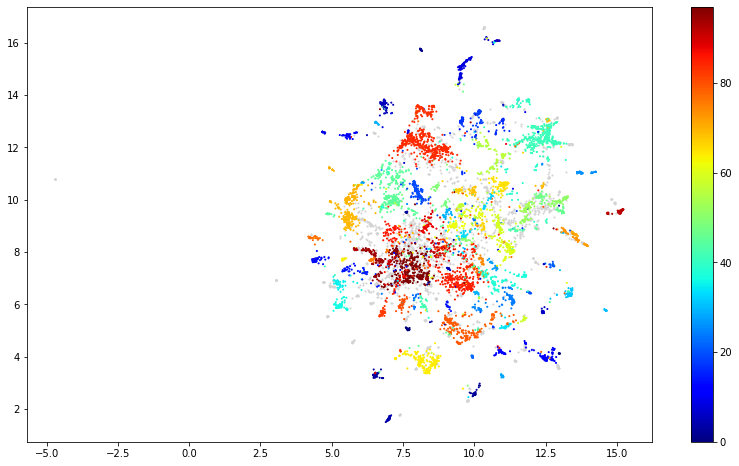

In [51]:
plot_clusters(embeddings_st1, best_clusters_st1)

In [52]:
results_df[results_df['label_st1']==44]

,Processed_Title,category,label_st1
7,Coronavirus live updates: US President Donald Trump declares coronavirus pandemic a national emergency,declares_emergency_coronavirus,44
232,Trump Declares Coronavirus National Emergency,declares_emergency_coronavirus,44
318,Trump declares national emergency over coronavirus outbreak,declares_emergency_coronavirus_pandemic,44
1423,Trump makes emergency announcement on coronavirus pandemic,declares_emergency_coronavirus_pandemic,44
1609,Donald Trump declares US national emergency over coronavirus,coronavirus_coronavirus_case,44
2022,Trump reportedly set to declare coronavirus a national emergency,declares_emergency_coronavirus,44
2086,Trump declares national emergency to contain coronavirus,declares_emergency_coronavirus_pandemic,44
2186,Trump approves major disaster declarations in N.Y. and Washington state due to coronavirus,approves_declaration_disaster_coronavirus,44
2477,Trump approves disaster declaration for coronavirus in California,approves_declaration_disaster_coronavirus,44
2924,Coronavirus: Trump declares national day of prayer in U.S.,declares_day_prayer_follower,44


## Save Clustered Title

In [53]:
results_df.to_csv('D:\\NLP\\Frame_NLP\\archive\\Sent_Cluster\\sample_clustered99.csv')

In [3]:
title_labels = pd.read_csv('D:\\NLP\\Frame_NLP\\archive\\Sent_Cluster\\labeled_clusters1229.csv')
title_labels.head()

,Processed_Title,label_st1,label
0,"US coronavirus death toll rises to 14, most cases in Washington",1044,rises_37_coronavirus_death
1,"Iran rejects U.S. offer for coronavirus aid, cites conspiracy theory",576,refuses_offer_coronavirus_conspiracy
2,TSA is making 3 changes to stop coronavirus from spreading on planes,913,expands_change_airport_coronavirus
3,NBA Players to Take Pay Cut Amidst Coronavirus Crisis,758,preparing_cut_coronavirus_game
4,"Coronavirus Cases confirmed in North Korea, say officials",355,coronavirus_exercise_case_week


In [10]:
title_labels[title_labels['label']=='coronavirus_coronavirus_case']

,Processed_Title,label_st1,label
10,Will Coronavirus Propel This Vaccine Maker's Stock Even Higher ?,-1,coronavirus_coronavirus_case
12,"Schools, colleges in HP to not hold mass gatherings amid coronavirus scare",-1,coronavirus_coronavirus_case
21,APhA Issues Preparedness and Prevention Guidance During Coronavirus Pandemic,-1,coronavirus_coronavirus_case
22,Sex and coronavirus: What you need to know,-1,coronavirus_coronavirus_case
24,India's Tata Motors warns of JLR profit hit due to coronavirus,-1,coronavirus_coronavirus_case
...,...,...,...
8308,Horror coronavirus outbreak linked to Coles grows,-1,coronavirus_coronavirus_case
8335,"Britain's coronavirus death toll at 15,464",-1,coronavirus_coronavirus_case
8340,Coronavirus should be a wake up call for a nation in denial,-1,coronavirus_coronavirus_case
8359,Minister to step in as Boris Johnson is hospitalised with coronavirus,-1,coronavirus_coronavirus_case


In [42]:
coronavirus_sample = title_labels[title_labels['label']=='coronavirus_coronavirus_case']
coronavirus_sample.shape

(1048, 3)

In [43]:
coronavirus_sample.to_csv('D:\\NLP\\Frame_NLP\\archive\\Sent_Cluster\\coronavirus_sample.csv')